In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, get_scorer_names
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import plot_tree, DecisionTreeClassifier, export_graphviz
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import random
from numpy import log

In [10]:
movie=pd.read_csv("../data/movie_metadata.csv")

In [11]:
def split_data(df, target, train_size=0.80, tune_size=0.10, random_state=21):
    # Split independent and dependent variables
    df = df[['num_critic_for_reviews','actor_1_facebook_likes','gross','num_voted_users','cast_total_facebook_likes','num_user_for_reviews','budget','imdb_score','movie_facebook_likes']]
    df['score'] = pd.cut(df['imdb_score'], bins=[0, 5, 7, 10], labels=['low', 'medium', 'high'])
    df = df.drop(columns=['imdb_score'])
    df = df.fillna(df.mean(numeric_only=True))
    X = df.drop(columns=target)
    y = df[target]
    
    # Split data into training and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, stratify=y, random_state=random_state)
    
    # Split the temporary set into tuning and testing sets
    X_tune, X_test, y_tune, y_test = train_test_split(X_temp, y_temp, train_size=tune_size, stratify=y_temp, random_state=random_state+28)
    
    return X_train, X_tune, X_test, y_train, y_tune, y_test

# Use the function to split the winequality data
X_train, X_tune, X_test, y_train, y_tune, y_test = split_data(movie, 'score')

/tmp/ipykernel_53935/4288835625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = pd.cut(df['imdb_score'], bins=[0, 5, 7, 10], labels=['low', 'medium', 'high'])


In [15]:
kf = RepeatedStratifiedKFold(n_splits=10, n_repeats =5, random_state=42)
scoring = ['accuracy', 'recall_macro', 'balanced_accuracy', 'f1_macro']



param={"max_depth" : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        #"splitter":["best","random"],
        #"min_samples_split":[5,10,15,20,25],
        #"min_samples_leaf":[5,10,15,20,25],
        #"min_weight_fraction_leaf":[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
        #"max_features":["auto","log2","sqrt",None],
        #"max_leaf_nodes":[10,20,30,40,50],
        #'min_impurity_decrease':[0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01],
        #'ccp_alpha' :[.001, .01, .1]
           }


cl= DecisionTreeClassifier(random_state=1000)

search = GridSearchCV(cl, param, scoring=scoring, n_jobs=1, cv=kf, refit='balanced_accuracy')


model = search.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=11, random_state=1000)


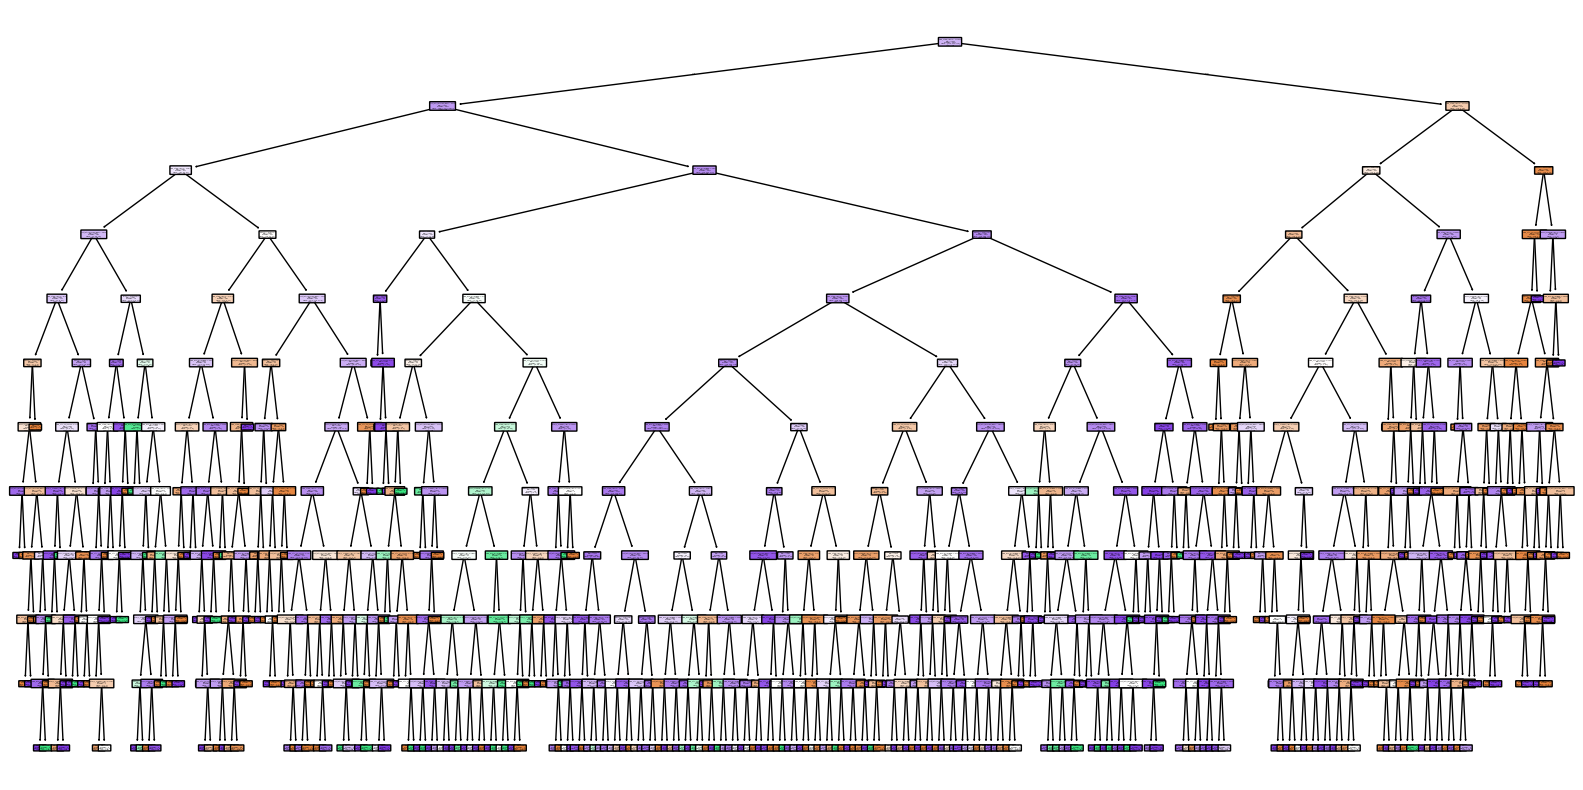

In [13]:
best = model.best_estimator_
print(best)

plt.figure(figsize=(20,10))
plot_tree(best, feature_names=X_train.columns, class_names=y_train.unique(), filled=True, rounded=True)
plt.show()

In [16]:
accuracy = model.cv_results_['mean_test_accuracy']
recall = model.cv_results_['mean_test_recall_macro']
bal_acc = model.cv_results_['mean_test_balanced_accuracy']
f1 = model.cv_results_['mean_test_f1_macro']

SDaccuracy = model.cv_results_['std_test_accuracy']
SDrecall = model.cv_results_['std_test_recall_macro']
SDbal_acc = model.cv_results_['std_test_balanced_accuracy']
SDf1 = model.cv_results_['std_test_f1_macro']

depth = np.unique(model.cv_results_['param_max_depth']).data

final_model = pd.DataFrame(list(zip(depth, accuracy, recall, bal_acc, f1, SDaccuracy, SDrecall, SDbal_acc, SDf1)),
               columns=['depth', 'accuracy', 'recall', 'bal_acc', 'f1', 'accuracySD', 'recallSD', 'bal_accSD', 'f1SD'])

print(final_model.head())

varimp = pd.DataFrame(best.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(varimp)

   depth  accuracy    recall   bal_acc        f1  accuracySD  recallSD  \
0      1  0.623800  0.407765  0.407765  0.386620    0.014114  0.015380   
1      2  0.622364  0.406821  0.406821  0.385619    0.016272  0.016083   
2      3  0.632077  0.417295  0.417295  0.397851    0.017339  0.015737   
3      4  0.641893  0.442482  0.442482  0.433892    0.019938  0.025409   
4      5  0.648285  0.463773  0.463773  0.467629    0.020625  0.031597   

   bal_accSD      f1SD  
0   0.015380  0.019905  
1   0.016083  0.020425  
2   0.015737  0.019489  
3   0.025409  0.035724  
4   0.031597  0.043212  
                           importance
num_voted_users              0.259900
budget                       0.159332
num_user_for_reviews         0.129841
gross                        0.123423
cast_total_facebook_likes    0.115863
num_critic_for_reviews       0.090700
movie_facebook_likes         0.067063
actor_1_facebook_likes       0.053877


In [ ]:
class_distribution = pd.Series(y_train).value_counts(normalize=True)
print("Class Distribution (Prevalence):")
print(class_distribution)


Class Distribution (Prevalence):
score
medium    0.580069
high      0.316063
low       0.103867
Name: proportion, dtype: float64
